In [24]:
from kiara.utils.graphs import pipeline_graph_to_image

try:
    from kiara_plugin.jupyter import ensure_kiara_plugins
except:
    import sys
    print("Installing 'kiara_plugin.jupyter'...")
    !{sys.executable} -m pip install -q kiara_plugin.jupyter
    from kiara_plugin.jupyter import ensure_kiara_plugins

KIARA_PLUGINS = ["kiara_plugin.onboarding", "kiara_plugin.language_processing"]
ensure_kiara_plugins(*KIARA_PLUGINS)

from kiara import KiaraAPI
kiara = KiaraAPI.instance()

# Extracting stages from a *kiara* pipeline

This notebook illustrates an important characteristic of a *kiara* pipeline: how it allows to extract groups of steps (called 'stages') from its structure, in different ways. I believe that this could be used to great effect in any UI we are going to write.

To understand this, let me explain a bit of context first:

## The pipeline structure

Below is the configuration for the pipeline we are going to work with. It is a basic topic modeling workflow, that produces 3 result outputs:

- `topic_models`
- `coherence_table` & `coherence_map` (if the input to calculate coherence is set to `True`)

In [25]:
PIPELINE_CONFIG = """
pipeline_name: topic_modeling
doc: A minimal topic-modeling end-to-end workflow.
steps:
  - module_type: import.local.file_bundle
    step_id: import_text_corpus
  - module_type: create.table.from.file_bundle
    step_id: create_text_corpus
    input_links:
      file_bundle: import_text_corpus.file_bundle
  - module_type: table.pick.column
    step_id: extract_texts_column
    input_links:
      table: create_text_corpus.table
  - module_type: tokenize.texts_array
    step_id: tokenize_content
    input_links:
      texts_array: extract_texts_column.array
  - module_type: create.stopwords_list
    step_id: create_stopwords_list
  - module_type: preprocess.tokens_array
    step_id: preprocess_corpus
    input_links:
      tokens_array: tokenize_content.tokens_array
      remove_stopwords: create_stopwords_list.stopwords_list
  - module_type: generate.LDA.for.tokens_array
    step_id: generate_lda
    input_links:
      tokens_array: preprocess_corpus.tokens_array

input_aliases:
  extract_texts_column.column_name: content_column_name
  import_text_corpus.path: text_corpus_folder_path
  tokenize_content.tokenize_by_word: tokenize_by_word
  generate_lda.num_topics_min: num_topics_min
  generate_lda.num_topics_max: num_topics_max
  generate_lda.compute_coherence: compute_coherence
  generate_lda.words_per_topic: words_per_topic
  create_stopwords_list.languages: languages
  create_stopwords_list.stopword_list: stopword_list
  preprocess_corpus.to_lowercase: to_lowercase
  preprocess_corpus.remove_alphanumeric: remove_alphanumeric
  preprocess_corpus.remove_non_alpha: remove_non_alpha
  preprocess_corpus.remove_all_numeric: remove_all_numeric
  preprocess_corpus.remove_short_tokens: remove_short_tokens
  preprocess_corpus.remove_stopwords: remove_stopwords

output_aliases:
  generate_lda.topic_models: topic_models
  generate_lda.coherence_map: coherence_map
  generate_lda.coherence_table: coherence_table
"""

### Creating the pipeline structure Python object

In [26]:
from kiara.models.module.pipeline import PipelineConfig

pipeline_config = PipelineConfig.from_string(PIPELINE_CONFIG)
structure = pipeline_config.structure

### Visualizing the overall pipeline structure

*kiara* can extract many things from the pipeline configuration data, most notably how the steps are connected internally (aka: which outputs of which steps connect to which inputs of which other steps).

We can draw the structure as a graph, in different ways. The easiest to follow graph type is called 'execution_graph' and ignores inputs and outputs entirely, and only shows the steps and their overall connections.

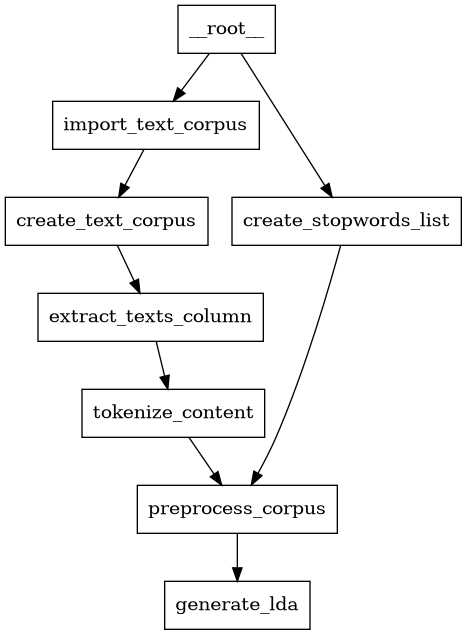

In [27]:
graph_type = "execution"  # try out the other possible options: 'data-flow-simple', "data-flow", "stages"
pipeline_graph_to_image(structure, graph_type=graph_type)

Note how the 'create_stopwords_list' is the odd one out, and remember that for the rest of this notebook, whenever you see a rendered graph. This pipeline is fairly simple, and it only has one 'parallel' branch, but I think it's realistic to expect that we'll have quite a few that are more complex, with a higher level of parallelism.

### Examine the other important pipeline characteristics

The execution graph is a good tool to quickly see in which order the different steps are executed within the pipeline. (Arguably) more important though, how a user can use a pipeline for their own purposes.

Let's look at the metadata that comes with a pipeline structure:

In [28]:
structure


pipeline
├── inputs
│   ├── text_corpus_folder_path (type: string)
│   ├── content_column_name (type: string)
│   ├── tokenize_by_word (type: boolean)
│   ├── languages (type: list)
│   ├── stopword_list (type: list)
│   ├── to_lowercase (type: boolean)
│   ├── remove_alphanumeric (type: boolean)
│   ├── remove_non_alpha (type: boolean)
│   ├── remove_all_numeric (type: boolean)
│   ├── remove_short_tokens (type: integer)
│   ├── num_topics_min (type: integer)
│   ├── num_topics_max (type: integer)
│   ├── compute_coherence (type: boolean)
│   └── words_per_topic (type: integer)
├── steps
│   ├── stage 1
│   │   └── step: import_text_corpus
│   │       └── module: import.local.file_bundle
│   ├── stage 2
│   │   └── step: create_text_corpus
│   │       └── module: create.table.from.file_bundle
│   ├── stage 3
│   │   └── step: extract_texts_column
│   │       └── module: table.pick.column
│   ├── stage 4
│   │   ├── step: tokenize_content
│   │   │   └── module: tokenize.texts_array
│   │   └── step: create_stopwords_list
│   │       └── module: create.stopwords_list
│   ├── stage 5
│   │   └── step: preprocess_corpus
│   │       └── module: preprocess.tokens_array
│   └── stage 6
│       └── step: generate_lda
│           └── module: generate.LDA.for.tokens_array
└── outputs
    ├── topic_models (type: dict)
    ├── coherence_table (type: table)
    └── coherence_map (type: dict)

This shows three things:

#### `inputs`

The (pipeline) inputs a user can set, for the lifetime of a pipeline, those will never change, unless a new step is added that has one or several inputs that are not connected to another steps output(s). *kiara* automatically creates the list of user inputs from the pipeline structure, by collecting all inputs from all steps that are not connected to an output of another step.

A pipeline creator can adjust the field name of inputs by setting it in the `input_aliases` section of the pipeline configuration, for example:

```yaml
input_aliases:
  extract_texts_column.column_name: content_column_name
  import_text_corpus.path: text_corpus_folder_path
```

Pipeline inputs that are not listed under `input_aliases` will have an auto-generated field name.

####`steps`

A list of steps, similar to the visual representation of the execution graph above. Note how the steps are grouped into 'stages'. More on that later, it's the main thing I want to explain in this notebook.

####`outputs`

The outputs the pipeline produces. This is a sub-set of all the outputs of all steps within the pipeline, selected by the pipeline author to indicate the 'main' outputs that are of interest in the context of a pipeline. The set of outputs is controlled by the 'output_aliases' section of the pipeline configuration, like this:

```yaml
output_aliases:
  generate_lda.topic_models: topic_models
  generate_lda.coherence_map: coherence_map
  generate_lda.coherence_table: coherence_table
```

If no `output_aliases` are defined, all outputs of all steps are considered to be pipeline outputs (with auto-generated pipeline names), but in most cases that would be a bit unwieldy and also unnecessary.


#### Other details

We can also investigate more details about each of the steps. In most cases, this won't be necessary, but I'll include some example code here, just in case:


In [29]:
structure.get_step_details("preprocess_corpus")


╭─ Step: preprocess_corpus ────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                                                          │
│   step_id       preprocess_corpus                                                                                                        │
│   module type   preprocess.tokens_array                                                                                                  │
│   module doc    Preprocess lists of tokens, incl. lowercasing, remove special characers, etc.                                            │
│                                                                                                                                          │
│                 Lowercasing: Lowercase the words. This operation is a double-edged sword. It can be effective at yielding potentially    │
│                 better results in the case of relatively small datasets or datatsets with a high percentage of OCR mistakes. For         │
│                 instance, if lowercasing is not performed, the algorithm will treat USA, Usa, usa, UsA, uSA, etc. as distinct tokens,    │
│                 even though they may all refer to the same entity. On the other hand, if the dataset does not contain such OCR           │
│                 mistakes, then it may become difficult to distinguish between homonyms and make interpreting the topics much harder.     │
│                                                                                                                                          │
│                 Removing stopwords and words with less than three characters: Remove low information words. These are typically words    │
│                 such as articles, pronouns, prepositions, conjunctions, etc. which are not semantically salient. There are numerous      │
│                 stopword lists available for many, though not all, languages which can be easily adapted to the individual               │
│                 researcher's needs. Removing words with less than three characters may additionally remove many OCR mistakes. Both       │
│                 these operations have the dual advantage of yielding more reliable results while reducing the size of the dataset,       │
│                 thus in turn reducing the required processing power. This step can therefore hardly be considered optional in TM.        │
│                                                                                                                                          │
│                 Noise removal: Remove elements such as punctuation marks, special characters, numbers, html formatting, etc. This        │
│                 operation is again concerned with removing elements that may not be relevant to the text analysis and in fact            │
│                 interfere with it. Depending on the dataset and research question, this operation can become essential.                  │
│   inputs                                                                                                                                 │
│                   field name                            type      description                            Required   Default              │
│                  ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────    │
│                   preprocess_corpus.tokens_array        array     The tokens array to pre-process.       yes        -- no default --     │
│                   preprocess_corpus.to_lowercase        boolean   Apply lowercasing to the text.         no         False                │
│                   preprocess_corpus.remove_alphanumer   boolean   Remove all tokens that include         no         False                │
│                   ic                              

Note how here the field names are assembled from the id of the step they belong to, and the field name of the input in the underlying module. This can be considered the 'address' of a value within a pipeline. The actual data of each of the fields will change over time, as a user sets different inputs, but this field name will stay the same, and can be used to access the current value.

## Pipeline stages

Now the important bit. Each step in a pipeline can only be executed when all of its inputs are set. This is obvious for the inputs of that step that are set by a user (in which case we need to wait for the user). If the input is connected to an output of another step though, this means that the other steps needs to have finished processing before this one can be kicked off. Steps that are executed in the same 'level' as other steps (meaning they need to have waited for the same dependency steps) can be grouped into what I call a 'stage'.

There are multiple ways how to group the steps of a pipeline into stages. The most obvious one would be to give each step its own stage, which for our example would look like this:



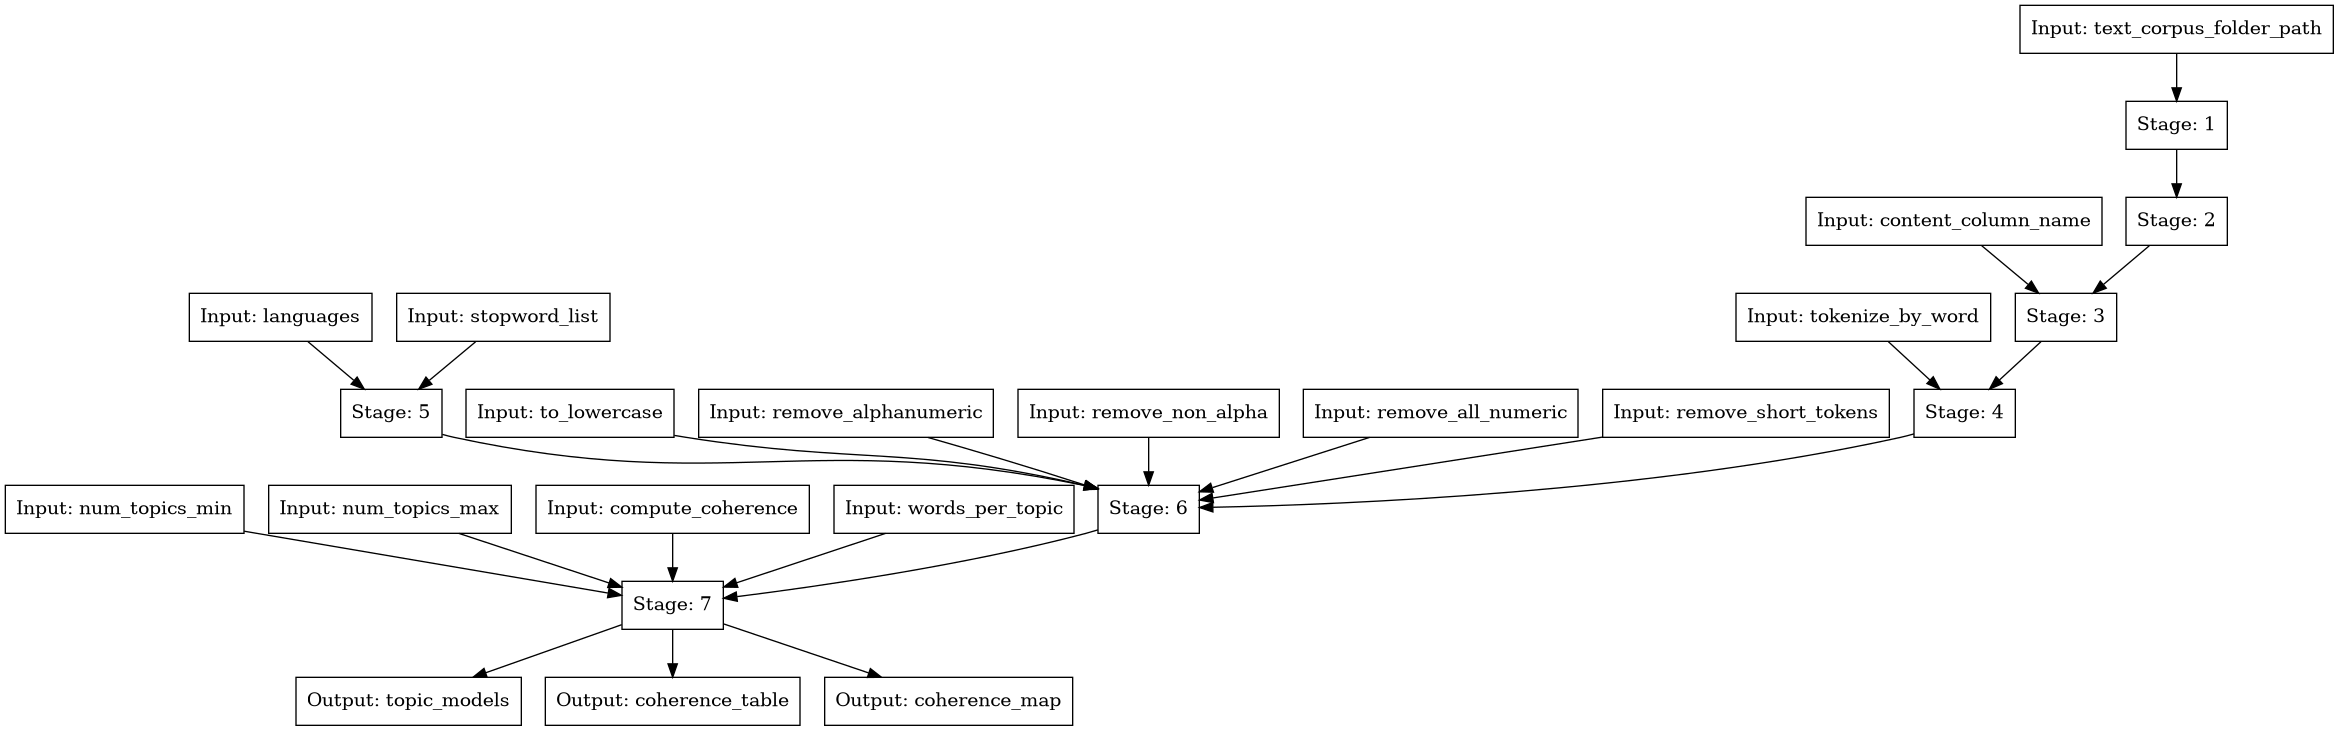

In [30]:
pipeline_graph_to_image(structure, graph_type="stages", stages_extraction_type="stage_per_step")


If we think about automatically rendering an UI for the user to provide inputs, each "Stage: X" node would represent a step where the user needs to select the inputs that feed into it, and click 'Process' to get to the next step.
The 'one-stage-per-step' strategy will give us the most detailed information about the flow the data goes through, but it will also be the most confusing (more nodes and connection mean a busier UI).

The other extreme in terms of splitting up a pipeline would be to just create a single stage, and throw all steps in it:

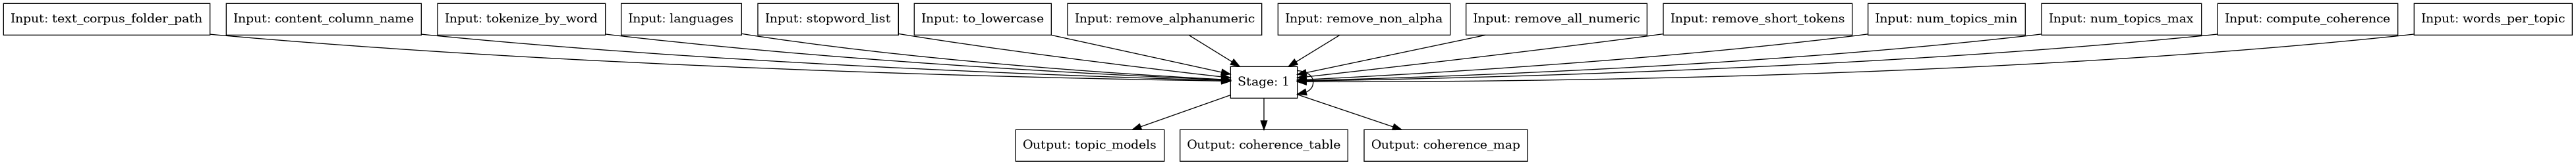

In [31]:
pipeline_graph_to_image(structure, graph_type="stages", stages_extraction_type="single_stage")


Translating this to a UI again, a user would set all inputs at the same time, and re-compute the whole pipeline every time they changed any of the inputs, and clicks 'Process'.

Both of those strategies have their advantages, but there are other strategies we can employ. There are two I call 'early' and 'late', who are very similar, but have a subtle difference: they schedule steps as early as possible, or as early as necessary. Both of them go through all steps, and figure out which ones can be processed at the same time (because their requirements will be satisfied at the same time), but 'late' will place a step in the last possible layer before it's result is needed, whereas 'early' places it as soon as possible (which, in practice only really applies for steps that require user input, and they will be added to the first stage, always). 'late' makes more sense if we want to auto-generate input forms, because that way user inputs are only asked when they are actually used, and not at the beginning, even though their input will be used 3 stages later, for example.

Here are the two graphs:

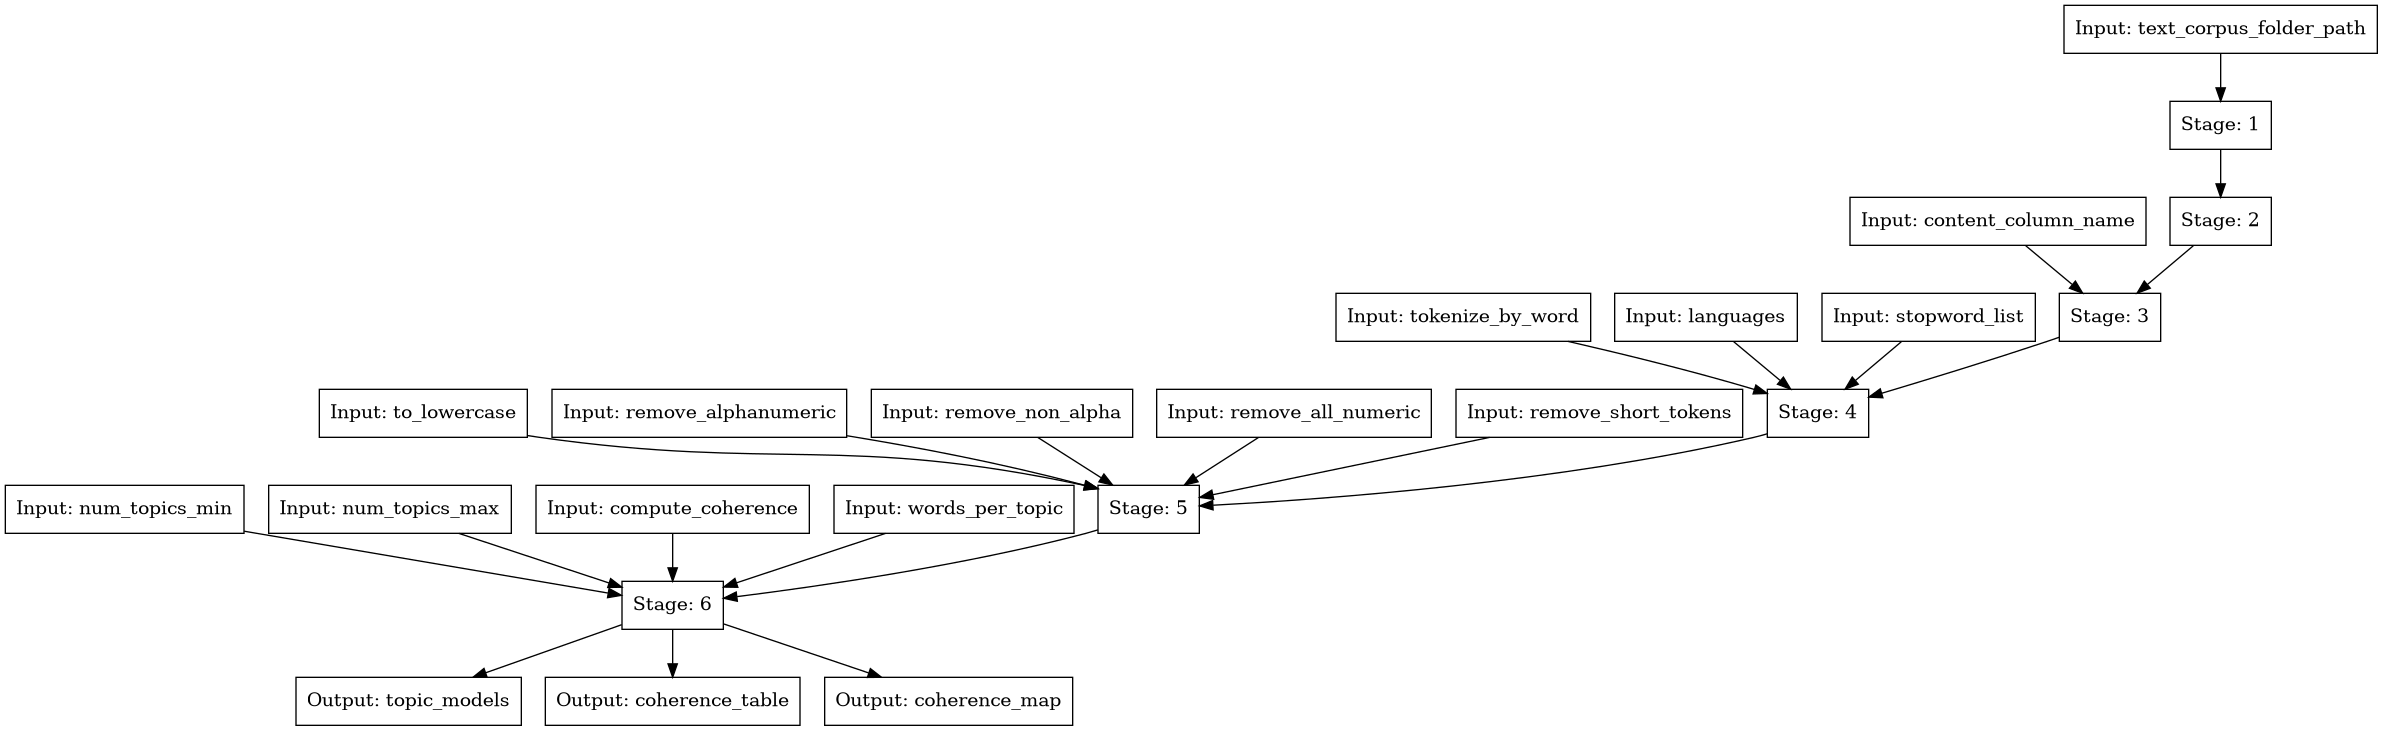

In [32]:
pipeline_graph_to_image(structure, graph_type="stages", stages_extraction_type="late")


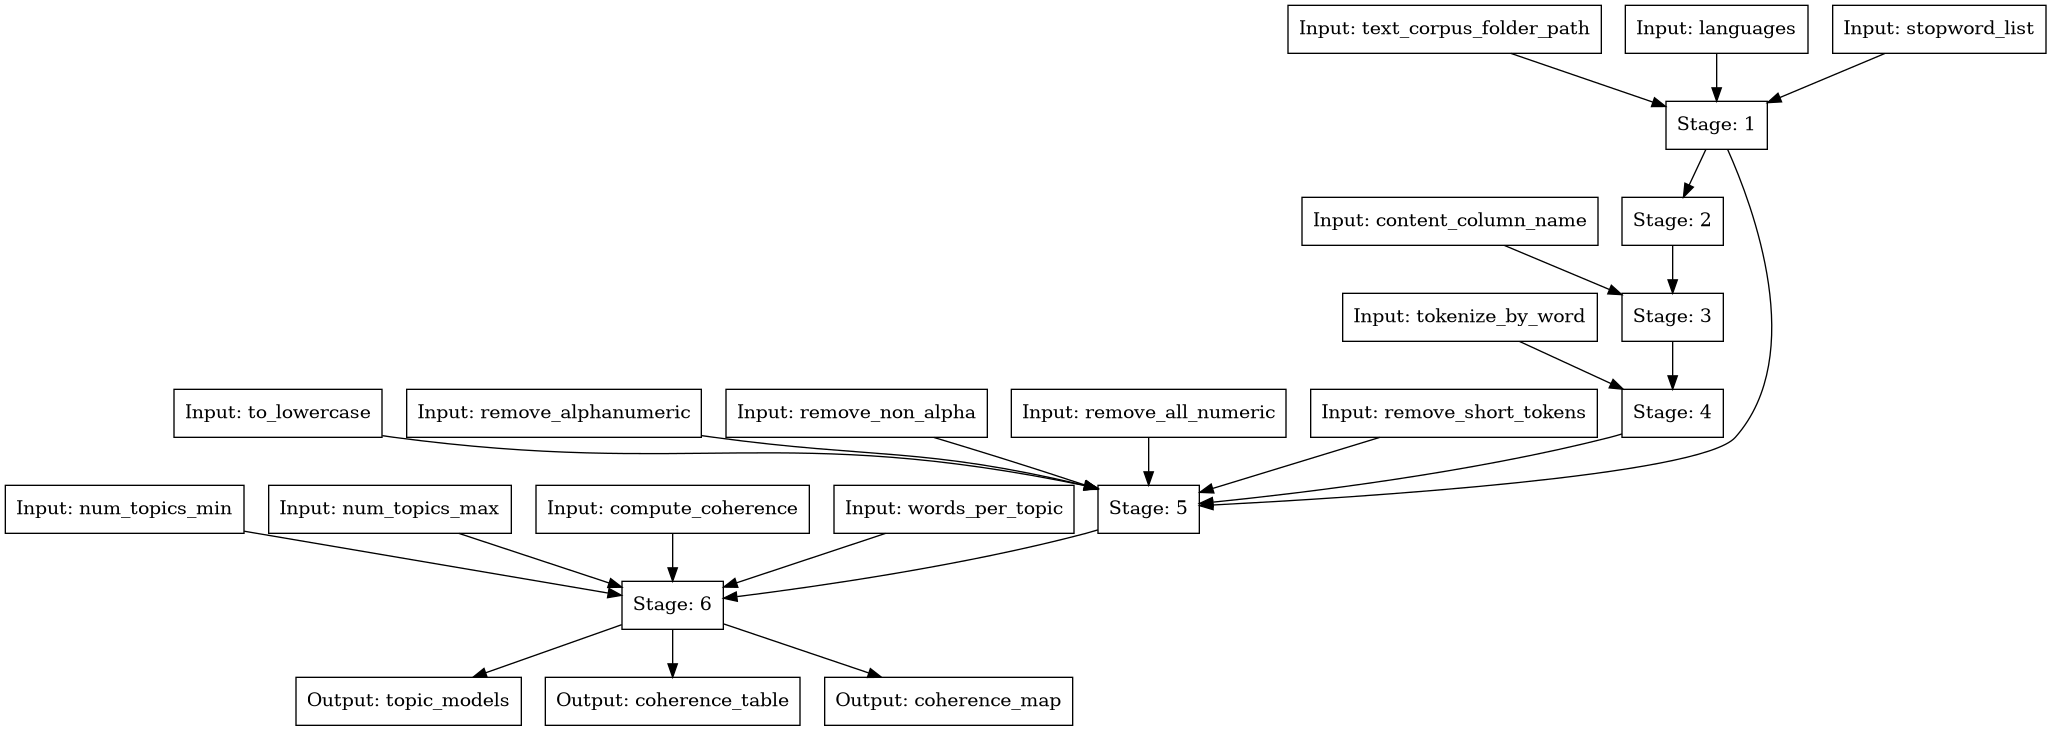

In [33]:
pipeline_graph_to_image(structure, graph_type="stages", stages_extraction_type="early")

It's a subtle difference, but check out how the 'languages' and 'stopword_lists' inputs are requested in different stages.

I haven't implemented other strategies to split up a pipeline into stages yet, but I want to have at least one more: a variation of 'late', where steps that don't have any user inputs (only connections to other step outputs) are merged with the previous stage. Because, if there is no user input, we can just process the step after we processed the previous one, without having to wait for any user input.

Also, I want to add an option for pipeline creators to group steps into stages that make sense from a 'research' perspective, meaning the creator will manually hint at the best way to present the order of steps to a user.

I'm not sure if any of this makes sense, but I think we'll have a hard time if we only have a single option to present a pipeline structure/order to users. The pipelines we'll be working with will differ a lot in terms of overall complexity and size, and unless we want to hand-craft a UI for all of them, I think the only option we have is to auto-generate one or several input forms per pipeline. Esp. large pipelines would become very unwieldy to display in a UI, even with zooming, scrolling.

An input form would map to a node in your figma wireframe. The crucial thing then would be how to split up those forms to provide the best user experience. If we do it like I propose, we could easily have a menu or set of buttons that lets users switch between different views of the same pipeline.

The nice thing is, we'd only need to create the code to auto-generate such a form once. And we'd feed in the information of one stage per form/node. If we want to change the way stages are split up, we just feed in 'broader' or 'slimmer' stages, and the generated UI would have less/more nodes with more/less input fields in each. If a user already set an input, that wouldn't change, since the input field name would be the same in each of the options.

Another thing I haven't mentioned is that we'll of course also have a lot more data and metadata we can show in the nodes (or connection between nodes), what I outline is really only the simplest way I could think of to explain how I imagine this working.